## Open farm and run simple diagnostic


## Load packages

In [2]:
# packages that have to be installed every runtime
import subprocess
import pkg_resources

required = {'rasterstats','odc-ui'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    import sys
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

In [3]:
import time
start = time.time()

import warnings
warnings.filterwarnings('ignore')

In [4]:
%%time
from grits import get_field, get_lims, get_mms, query_l2a_items, xr_rasterize, calculate_indices

# the basic
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

# for PC, stac, xarray
import stackstac
from xrspatial import zonal_stats

# From DEA
import sys
sys.path.append('/home/jovyan/PlanetaryComputerExamples/grasspace/deafrica-sandbox-notebooks/Tools/deafrica_tools/')
from plotting import display_map, rgb, map_shapefile

CPU times: user 2.84 s, sys: 973 ms, total: 3.81 s
Wall time: 3.56 s


## Área de análise
Using function get_field for 

1. for fields in a farm - OK
2. for a group in a group of farms - OK
3. for specific fields in a farm - OK
4. ToDo - for an entire farm - the simplest case, as if the polygon was already given straight from a file

In [5]:
path = '/home/jovyan/PlanetaryComputerExamples/vetorial/FAZENDAS/'

# daterange analysis
datetime = "2022-07-10/2023-09-28"


#### Área: Fazenda Uniguiri
**Column parte** contém as regiões

In [6]:

field = gpd.read_file( path + 'fazenda_uniguiri.gpkg', layer = 'piquetes_TID')
bbox, lat_range, lon_range = get_lims(field)

print(field.head())
#field.plot()

got bbox, lat_range, lon_range
    PID  area_ha    R   ID      SR     Re   Fi     TID  \
0  R8_4      6.4  R8_    4  100000  80000    4  180004   
1     F     10.6    F  NaN  100000  80000  901  180901   
2  R8_5      6.9  R8_    5  100000  80000    5  180005   
3     C      0.7    C  NaN  100000  80000  801  180801   
4  R8_1      6.7  R8_    1  100000  80000    1  180001   

                                            geometry  
0  MULTIPOLYGON (((-54.57526 -16.95986, -54.57705...  
1  MULTIPOLYGON (((-54.57224 -16.96252, -54.57131...  
2  MULTIPOLYGON (((-54.57705 -16.96167, -54.57526...  
3  MULTIPOLYGON (((-54.56787 -16.95268, -54.56744...  
4  MULTIPOLYGON (((-54.57109 -16.95544, -54.57249...  


#### Área: Iacanga - Cana

Grupo de talhoes dentro de todas fazendas de uma usina


### Display bbox study area


In [7]:
style={'opacity': 6, 'stroke': 2,'dashArray': '1', 'fillOpacity': 0.5}
map_shapefile(field,'TID',cmap='prism', **style )

Label(value='')

Map(center=[-16.952624537376447, -54.60751486634523], controls=(ZoomControl(options=['position', 'zoom_in_text…

## Get images

### get Sentinel 2 L2A Data
colocar as especificidades aqui

In [8]:
%%time
items = query_l2a_items(bbox, datetime, 30)

 found 40 items
CPU times: user 166 ms, sys: 18.3 ms, total: 184 ms
Wall time: 1.09 s


In [9]:
# For Sentinel 2
data = (
    stackstac.stack(
        items,
        assets = ["B11","B12","B08","B06", "B04", "B03","B02", "SCL"],    #["B12","B11","B08","B08","B05","B04","B03","B02"],  
        chunksize=256,
        #resolution=0.0001, #0.0001
        epsg=4326,
        bounds=bbox,
        properties = True,
        fill_value = np.nan,
    )
    .where(lambda x: x > 0, other=np.nan)  # sentinel-2 uses 0 as nodata
    .assign_coords(band=lambda x: x.common_name.rename("band"))  # use common names
)

# fix xy names
data = data.rename({'x': 'longitude','y': 'latitude'})

data

<xarray.DataArray 'stackstac-d5b06a80d164a7fc6de9af54ddb899c2' (time: 40,
                                                                band: 8,
                                                                latitude: 369,
                                                                longitude: 942)>
dask.array<where, shape=(40, 8, 369, 942), dtype=float64, chunksize=(1, 1, 256, 256), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 2022-07-12...
    id                                       (time) <U54 'S2B_MSIL2A_20220712...
  * band                                     (band) object 'swir16' ... None
  * longitude                                (longitude) float64 -54.65 ... -...
  * latitude                                 (latitude) float64 -16.94 ... -1...
    s2:processing_baseline                   (time) <U5 '04.00' ... '05.09'
    ...                                       ...
    gsd                                      (band) float64 20.0 20.0 ... 20.0
    title                                    (band) <U36 'Band 11 - SWIR (1.6...
    common_name                              (band) object 'swir16' ... None
    center_wavelength                        (band) object 1.61 2.19 ... None
    full_width_half_max                      (band) object 0.143 0.242 ... None
    epsg                                     int64 4326
Attributes:
    spec:           RasterSpec(epsg=4326, bounds=(-54.65198199605766, -16.969...
    crs:            epsg:4326
    transform:      | 0.00, 0.00,-54.65|\n| 0.00,-0.00,-16.94|\n| 0.00, 0.00,...
    resolution_xy:  (9.439942722622163e-05, 9.118049409906348e-05)

### Mask dataset com fazenda

In [10]:
%%time
#create mask versao dataarray
# which also helps to reduce data size
mask = xr_rasterize(field,data,
                    # x_dim='x',
                    # y_dim='y',
                   #export_tiff='masked2.tiff',
                   ) 

# #mask data
data = data.where(mask)

# #convert to float 32 to conserve memory
data = data.astype(np.float32)
data

CPU times: user 32.4 ms, sys: 3.7 ms, total: 36.1 ms
Wall time: 34 ms


<xarray.DataArray 'stackstac-d5b06a80d164a7fc6de9af54ddb899c2' (time: 40,
                                                                band: 8,
                                                                latitude: 369,
                                                                longitude: 942)>
dask.array<astype, shape=(40, 8, 369, 942), dtype=float32, chunksize=(1, 1, 256, 256), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 2022-07-12...
    id                                       (time) <U54 'S2B_MSIL2A_20220712...
  * band                                     (band) object 'swir16' ... None
  * longitude                                (longitude) float64 -54.65 ... -...
  * latitude                                 (latitude) float64 -16.94 ... -1...
    s2:processing_baseline                   (time) <U5 '04.00' ... '05.09'
    ...                                       ...
    gsd                                      (band) float64 20.0 20.0 ... 20.0
    title                                    (band) <U36 'Band 11 - SWIR (1.6...
    common_name                              (band) object 'swir16' ... None
    center_wavelength                        (band) object 1.61 2.19 ... None
    full_width_half_max                      (band) object 0.143 0.242 ... None
    epsg                                     int64 4326
Attributes:
    spec:           RasterSpec(epsg=4326, bounds=(-54.65198199605766, -16.969...
    crs:            epsg:4326
    transform:      | 0.00, 0.00,-54.65|\n| 0.00,-0.00,-16.94|\n| 0.00, 0.00,...
    resolution_xy:  (9.439942722622163e-05, 9.118049409906348e-05)

In [11]:
# calcula indices
ds_ = data.to_dataset(dim='band')

# os indices
indices = ["LAI", "EVI","NDCI","BSI"]
ds = calculate_indices(ds_, 
                       index= indices, 
                       satellite_mission='s2', 
                       drop=True);

Dropping bands ['swir16', 'swir22', 'nir', 'rededge', 'red', 'green', 'blue', None]


In [12]:
%%time
ds.compute()

CPU times: user 26.5 s, sys: 7.94 s, total: 34.5 s
Wall time: 15.2 s


<xarray.Dataset>
Dimensions:                                  (time: 40, longitude: 942,
                                              latitude: 369, band: 8)
Coordinates: (12/43)
  * time                                     (time) datetime64[ns] 2022-07-12...
    id                                       (time) <U54 'S2B_MSIL2A_20220712...
  * longitude                                (longitude) float64 -54.65 ... -...
  * latitude                                 (latitude) float64 -16.94 ... -1...
    s2:processing_baseline                   (time) <U5 '04.00' ... '05.09'
    s2:datatake_type                         <U8 'INS-NOBS'
    ...                                       ...
    gsd                                      (band) float64 20.0 20.0 ... 20.0
    title                                    (band) <U36 'Band 11 - SWIR (1.6...
    common_name                              (band) object 'swir16' ... None
    center_wavelength                        (band) object 1.61 2.19 ... None
    full_width_half_max                      (band) object 0.143 0.242 ... None
    epsg                                     int64 4326
Dimensions without coordinates: band
Data variables:
    LAI                                      (time, latitude, longitude) float32 ...
    EVI                                      (time, latitude, longitude) float32 ...
    NDCI                                     (time, latitude, longitude) float32 ...
    BSI                                      (time, latitude, longitude) float32 ...
Attributes:
    spec:           RasterSpec(epsg=4326, bounds=(-54.65198199605766, -16.969...
    crs:            epsg:4326
    transform:      | 0.00, 0.00,-54.65|\n| 0.00,-0.00,-16.94|\n| 0.00, 0.00,...
    resolution_xy:  (9.439942722622163e-05, 9.118049409906348e-05)

## Criar zonas

Rasterizing to match xarray.DataArray dimensions (369, 942)
CPU times: user 161 ms, sys: 26.5 ms, total: 188 ms
Wall time: 183 ms


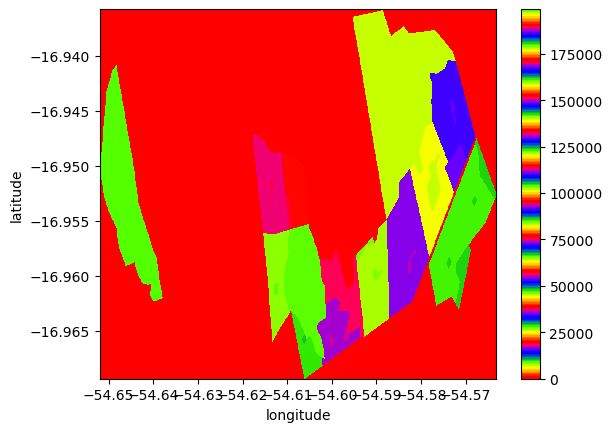

In [13]:
%%time
column = 'TID'
fm = xr_rasterize(field,data,attribute_col=column,verbose=True)
fm = fm.chunk(256)
fm.astype('uint8')
# fm_f64 = fm.astype('float64')
# fm_u8 = fm.astype('uint8')

fm.plot(cmap='prism')

### Calculate stats for IVs dataset

#### single image

#### for a series

In [40]:
%%time
nameout = 'TID_short_uniguiri'
verbose = False
stats_funcs = ['mean','std']
for iv in indices[1:3]:

    # get stats for the first dataframe
    data_ = ds[iv].sel(time=ds[iv].time.values[0]).squeeze()
    print('computing stats for the first date')
    #outst = zonal_stats(zones=fm, values=data_).compute()
    if stats_funcs == None:
        outst = zonal_stats(zones=fm, values=data_).compute()
    else:
        outst = zonal_stats(zones=fm, 
                         values = data_,
                         stats_funcs=stats_funcs).compute()
            
    outst['date'] = str(ds[iv].time.values[0]).split('T')[0]
    data_.close()

    # and through the loop
    for t in data.time.values[1:]:
        data_ = ds[iv].sel(time=t).squeeze()
        if verbose: print(f'computing stats for {t}')
        
        if stats_funcs == None:
            outst1 = zonal_stats(zones=fm, values=data_).compute()
        else:
            outst1 = zonal_stats(zones=fm, 
                                 values = data_,
                                 stats_funcs=stats_funcs).compute()
        outst1['date'] = str(t).split('T')[0]
        outst = pd.concat([outst,outst1])
        data_.close()
        del outst1

    outst.to_csv(f'/home/jovyan/PlanetaryComputerExamples/myout_csv/grasspace/{nameout}_{iv}.csv')
    print(f'{nameout}_{iv}.csv SAVED \n \n')
    del outst

computing stats for the first date
TID_short_uniguiri_EVI.csv SAVED 
 

computing stats for the first date
TID_short_uniguiri_NDCI.csv SAVED 
 

CPU times: user 10.3 s, sys: 1.83 s, total: 12.1 s
Wall time: 8.09 s


In [28]:
len(field.TID)

111

In [37]:
str(data.time.values[3]).split('T')[0]


'2023-07-27'

In [32]:
x.dtype

dtype('<M8[ns]')

### Calculare stats for single image

### Calculate stats for a series

In [13]:
end = time.time()
print(f'{(end - start):.0f} seconds')

28 seconds
